---
## Step 0: Load The Data

In [1]:
import tensorflow as tf
print(tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory rowth must be set before GPUs have been initialized
    print(e)
    
# config = tf.ConfigProto()
# config.gpu_option.per_process_gpu_memory_fraction = 0.4
# session = tf.Session(config=config)
# session.close()

2.2.0
1 Physical GPUs, 1 Logical GPUs


In [2]:
import csv
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow import keras
from sklearn.utils import shuffle
import seaborn as sns

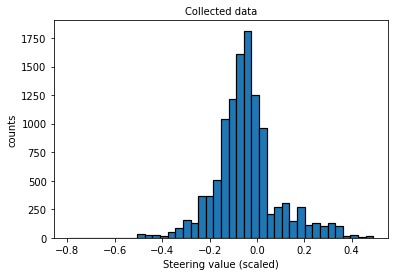

In [41]:
lines = []
center_img, left_img, right_img, steer_val = [],[],[],[]

path = '../../../Udacity/self-driving-car-game/0.driving_data/driving_log.csv'

with open(path) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if float(line[3]) != 0.0:
            center_img.append(line[0])
            left_img.append(line[1])
            right_img.append(line[2])
            steer_val.append(float(line[3]))
            
        else:
            prob = np.random.uniform()
            if prob <= 0.2:
                center_img.append(line[0])
                left_img.append(line[1])
                right_img.append(line[2])
                steer_val.append(float(line[3]))
            
            

f = plt.hist(steer_val, bins = 40, edgecolor='black', linewidth = 1.2)
plt.title('Collected data', fontsize = 10)
plt.xlabel('Steering value (scaled)')
plt.ylabel('counts')
plt.savefig('output_fig/1.collected_data.jpg')

steer_val = np.array(steer_val)
steer_val = np.around(steer_val,3)


In [5]:

def BGR2RGB(img):
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_RGB


def extract_array(img_path):
    images = []
    for line in img_path:
        source_path = line
        filename = source_path.split('\\')[-1]
        current_path = '../../../Udacity/self-driving-car-game/0.driving_data/IMG/' + filename
        image = cv2.imread(current_path)
        image = BGR2RGB(image)
        images.append(image)
    return images



def Flip(imgs):
    images = []
    for img in imgs:
        image = cv2.flip(img,1)
        images.append(image)
        
    return images

In [6]:
## make left / center / right img, steer data

offset = 0.1

images_left = extract_array(left_img)
steers_left = steer_val + offset

images_center = extract_array(center_img)
steers_center = steer_val

images_right = extract_array(right_img)
steers_right = steer_val - offset

In [7]:
images_left_flip = Flip(images_left)
steers_left_flip = -steers_left


images_center_flip = Flip(images_center)
steers_center_flip = -steers_center


images_right_flip = Flip(images_right)
steers_right_flip = -steers_right

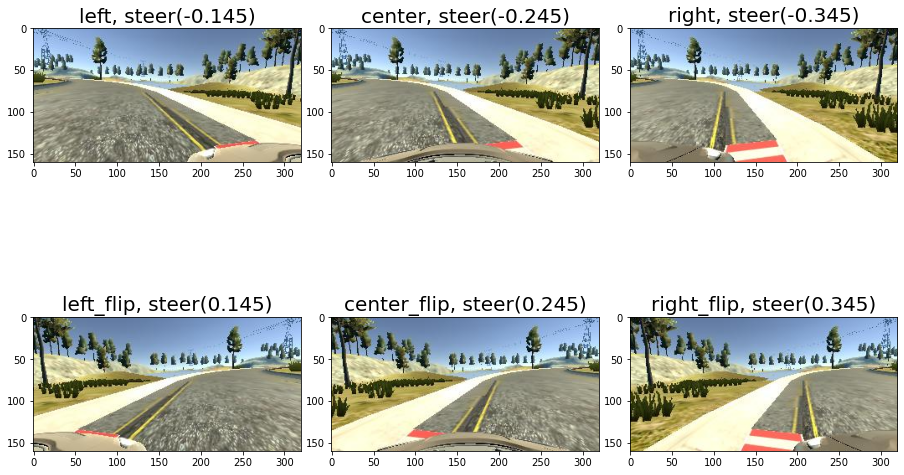

In [35]:
index = np.random.randint(len(steer_val)+1)

image_left = images_left[index]
image_center = images_center[index]
image_right = images_right[index]

steer_left = steers_left[index]
steer_center = steers_center[index]
steer_right = steers_right[index]


image_left_flip = images_left_flip[index]
image_center_flip = images_center_flip[index]
image_right_flip = images_right_flip[index]

steer_left_flip = steers_left_flip[index]
steer_center_flip = steers_center_flip[index]
steer_right_flip = steers_right_flip[index]



f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(15, 10))
ax1.imshow(image_left)
ax1.set_title('left, '+'steer('+str(steer_left)+')', fontsize=20)
ax2.imshow(image_center)
ax2.set_title('center, '+'steer('+str(steer_center)+')', fontsize=20)
ax3.imshow(image_right)
ax3.set_title('right, '+'steer('+str(steer_right)+')', fontsize=20)
ax4.imshow(image_left_flip)
ax4.set_title('left_flip, '+'steer('+str(steer_left_flip)+')', fontsize=20)
ax5.imshow(image_center_flip)
ax5.set_title('center_flip, '+'steer('+str(steer_center_flip)+')', fontsize=20)
ax6.imshow(image_right_flip)
ax6.set_title('right_flip, '+'steer('+str(steer_right_flip)+')', fontsize=20)

f.tight_layout()
f.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.0)
f.savefig('output_fig/2.Augmented_Image(SideCam_Flip).jpg')


    
    
    

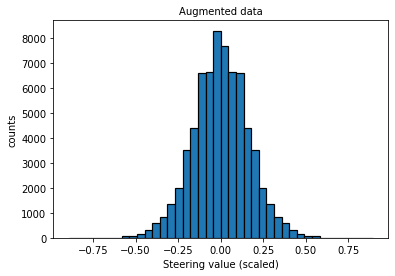

In [42]:
images = images_left + images_center + images_right \
        + images_left_flip + images_center_flip + images_right_flip
images = np.array(images)

steers = np.append(steers_left,steers_center)
steers = np.append(steers,steers_right)
steers = np.append(steers,steers_left_flip)
steers = np.append(steers,steers_center_flip)
steers = np.append(steers,steers_right_flip)

# images =  images_center +  images_center_flip 
# images = np.array(images)

# steers = np.append(steers_center,steers_center_flip)



f = plt.hist(steers, bins = 40, edgecolor='black', linewidth = 1.2)
plt.title('Augmented data', fontsize = 10)
plt.xlabel('Steering value (scaled)')
plt.ylabel('counts')
plt.savefig('output_fig/3.Augmented_data.jpg')

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Lambda, Cropping2D

drop_rate = 0.4

model = keras.models.Sequential([
    keras.layers.Cropping2D(cropping=((70,25),(0,0)),input_shape = (160, 320, 3)),
    keras.layers.Lambda(lambda x : x/255.0 - 0.5),
    keras.layers.Conv2D(filters = 24,kernel_size = (5,5), strides = (2,2),  padding = 'same'),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(filters = 36,kernel_size = (5,5), strides = (2,2),  padding = 'same'),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(filters = 48,kernel_size = (5,5), strides = (2,2),  padding = 'same'),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(filters = 64,kernel_size = (3,3), strides = (1,1),  padding = 'same'),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Conv2D(filters = 64,kernel_size = (3,3), strides = (1,1),  padding = 'same'),
    keras.layers.Activation('relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation = 'relu'),
    keras.layers.Dropout(rate=drop_rate),
    keras.layers.Dense(50, activation = 'relu'),
    keras.layers.Dropout(rate=drop_rate),
    keras.layers.Dense(10, activation = 'relu'),
    keras.layers.Dense(1)
])


model.summary()
model.compile(optimizer = keras.optimizers.Adam(),
             loss = 'mse', metrics = ['mae'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d (Cropping2D)      (None, 65, 320, 3)        0         
_________________________________________________________________
lambda (Lambda)              (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 33, 160, 24)       1824      
_________________________________________________________________
activation (Activation)      (None, 33, 160, 24)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 80, 36)        21636     
_________________________________________________________________
activation_1 (Activation)    (None, 17, 80, 36)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 40, 48)         4

In [14]:
history = model.fit(x_train, y_train, epochs = 100, batch_size = 256,
                    callbacks = [keras.callbacks.EarlyStopping(patience=5,monitor='val_loss',mode = 'min',verbose = 1 )],
                    validation_split = 0.3 , verbose = 1, shuffle = True  )

Epoch 1/100
189/189 [==============================] - 29s 151ms/step - loss: 0.0107 - mae: 0.0802 - val_loss: 0.0067 - val_mae: 0.0634
Epoch 2/100
189/189 [==============================] - 26s 136ms/step - loss: 0.0066 - mae: 0.0625 - val_loss: 0.0048 - val_mae: 0.0530
Epoch 3/100
189/189 [==============================] - 26s 136ms/step - loss: 0.0053 - mae: 0.0559 - val_loss: 0.0054 - val_mae: 0.0554
Epoch 4/100
189/189 [==============================] - 26s 136ms/step - loss: 0.0046 - mae: 0.0514 - val_loss: 0.0046 - val_mae: 0.0512
Epoch 5/100
189/189 [==============================] - 26s 136ms/step - loss: 0.0042 - mae: 0.0489 - val_loss: 0.0040 - val_mae: 0.0465
Epoch 6/100
189/189 [==============================] - 26s 136ms/step - loss: 0.0037 - mae: 0.0460 - val_loss: 0.0037 - val_mae: 0.0451
Epoch 7/100
189/189 [==============================] - 26s 136ms/step - loss: 0.0034 - mae: 0.0438 - val_loss: 0.0040 - val_mae: 0.0463
Epoch 8/100
189/189 [===========================

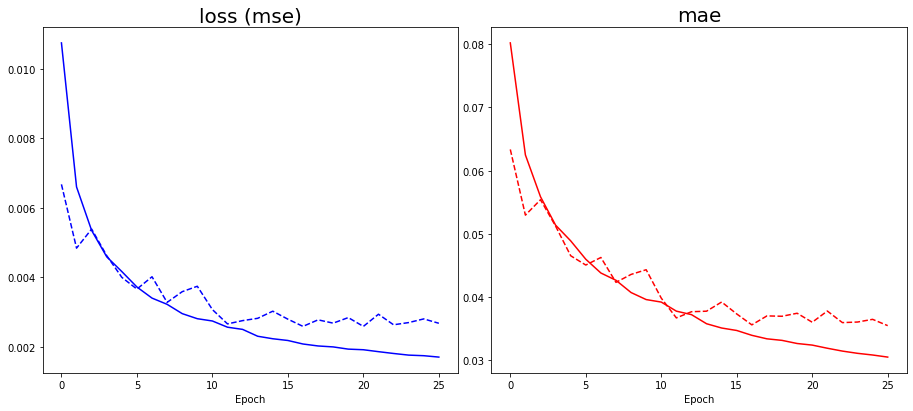

In [40]:
history.history
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(history.history['loss'], '-b', label = 'loss')
ax1.plot(history.history['val_loss'], '--b', label = 'val_loss')
ax2.plot(history.history['mae'], '-r', label = 'mae')
ax2.plot(history.history['val_mae'], '--r', label = 'val_mae')
ax1.set_title('loss (mse)', fontsize=20)
ax1.set_xlabel('Epoch')
ax2.set_title('mae', fontsize=20)
ax2.set_xlabel('Epoch')
f.tight_layout()
f.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
f.savefig('output_fig/4.Train_History.jpg')

In [16]:
model.save('model_temp.h5')